## Extracting Text from Image

In [1]:
import pytesseract
from PIL import Image
from textblob import TextBlob
import matplotlib.pyplot as plt
import os
import time

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

ModuleNotFoundError: No module named 'pytesseract'

In [9]:
def extract_text(image_path):
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img)
    return text

In [11]:
orginal_genre = []
for genre in os.listdir("book-covers"):
    orginal_genre.append(genre)

In [18]:
from tqdm import tqdm

genre_class = []
image_text = []
for genre in tqdm(orginal_genre,desc="Genre Progess"):
    for img in os.listdir("book-covers/"+genre):
        text = extract_text("book-covers/"+genre+"/"+img)
        genre_class.append(genre)
        image_text.append(text)

Genre Progess: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [1:54:23<00:00, 207.97s/it]


## Creating DataFrame and cleaning Image text

In [21]:
import pandas as pd
extracted_data = pd.DataFrame()
extracted_data['Image_Text'] = image_text.copy()
extracted_data['Genre'] = genre_class.copy()

In [29]:
import string

clean_text = []
for text in image_text:
    text = text.lower()
    text = ' '.join(text.split())
    text = text.translate(str.maketrans('', '', string.punctuation))
    clean_text.append(text)

In [31]:
extracted_data['Image_Text'] = clean_text.copy()

### Saving the cleaned data 

In [32]:
extracted_data.to_csv("Extracted_data.csv")

In [33]:
extracted_data.head()

,Image_Text,Genre
0,se ai b jk rowling ns fantastic beasts origina...,Art-Photography
1,mindfulness colouring book,Art-Photography
2,igen al soe i onioinay®,Art-Photography
3,,Art-Photography
4,,Art-Photography


# Taking 18 GENRE For Model

In [9]:
import pandas as pd
df = pd.read_csv("Extracted_data.csv")

In [10]:
df = df.iloc[:17000,1:]
df = df.dropna()

In [11]:
df.nunique()

Image_Text    6190
Genre           18
dtype: int64

# LSTM MODEL

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping

In [13]:
X = df['Image_Text'].values
y = df['Genre'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

y = pd.get_dummies(y)
num_classes = y.shape[1]

In [14]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [15]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.fit(X, y, epochs=20, batch_size=64)

Epoch 1/20
125/125 [==============================] - 18s 87ms/step - loss: 2.8358 - accuracy: 0.0833
Epoch 2/20
125/125 [==============================] - 11s 84ms/step - loss: 2.4541 - accuracy: 0.2717
Epoch 3/20
125/125 [==============================] - 10s 82ms/step - loss: 1.5511 - accuracy: 0.5367
Epoch 4/20
125/125 [==============================] - 10s 82ms/step - loss: 1.0106 - accuracy: 0.6642
Epoch 5/20
125/125 [==============================] - 10s 82ms/step - loss: 0.7945 - accuracy: 0.7029
Epoch 6/20
125/125 [==============================] - 10s 82ms/step - loss: 0.6828 - accuracy: 0.7154
Epoch 7/20
125/125 [==============================] - 10s 82ms/step - loss: 0.6178 - accuracy: 0.7233
Epoch 8/20
125/125 [==============================] - 10s 82ms/step - loss: 0.5829 - accuracy: 0.7160
Epoch 9/20
125/125 [==============================] - 10s 83ms/step - loss: 0.5522 - accuracy: 0.7229
Epoch 10/20
125/125 [==============================] - 10s 83ms/step - loss: 0.535

## Checking Efficiency

In [17]:
y_arr = np.array(y)
y_org = np.argmax(y_arr,axis=1)

y_pred = model.predict(X,verbose=0)
y_pred = np.argmax(y_pred,axis=1)

#### Save the model

In [18]:
model.save("model.h5")

In [21]:
from sklearn.metrics import accuracy_score,classification_report
print("FOR 18 GENRE :::\n ")
print("Accuracy : ",round(accuracy_score(y_org,y_pred)*100,2),"%")
print("\nClassification Report : \n",classification_report(y_org,y_pred))

FOR 18 GENRE :::
 
Accuracy :  79.14 %

Classification Report : 
               precision    recall  f1-score   support

           0       0.68      0.32      0.43       373
           1       0.64      0.56      0.60       476
           2       0.94      0.74      0.83       615
           3       0.97      0.89      0.93       404
           4       0.92      0.96      0.94       548
           5       0.80      0.80      0.80       383
           6       0.91      0.94      0.93       485
           7       0.84      0.95      0.89       510
           8       0.53      0.90      0.67       348
           9       0.77      0.92      0.84       409
          10       0.81      0.89      0.85       162
          11       0.74      0.58      0.65       583
          12       0.77      0.87      0.82       538
          13       0.86      0.82      0.84       419
          14       0.78      0.75      0.76       456
          15       0.80      0.75      0.77       608
          16   

# Calculating percentage and plotting

In [22]:
import re
import pandas as pd
from textblob import TextBlob

# Define a function to conduct sentimental analysis on the text
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentimental analysis to the 'text' column
df['sentiment'] = df['Image_Text'].apply(get_sentiment)

# Predict the genre for each row in 'text'
genre = model.predict(X)
genre = np.argmax(genre,axis=1)
df['predicted_genre'] = list(genre)

249/249 [==============================] - 3s 14ms/step


In [23]:
genres = list(df['Genre'].unique())
df['predicted_genre'] = [genres[i] for i in y_pred]

In [24]:
import pandas as pd
from tabulate import tabulate

sentiments = ['positive', 'neutral', 'negative']
table = []
for genre in df['Genre'].unique():
    genre_df = df[df['Genre'] == genre]
    
    # Calculate the percentage of sentiments for the current genre
    genre_sentiments = genre_df['sentiment'].value_counts(normalize=True)
    
    row = [genre]
    for sentiment in sentiments:
        if sentiment in genre_sentiments:
            percentage = round(genre_sentiments[sentiment] * 100, 2)
        else:
            percentage = 0
        row.append(str(percentage) + '%')

    # Calculate the percentage of predicted genres for the current genre
    predicted_genre_counts = genre_df['predicted_genre'].value_counts(normalize=True)
    predicted_genres = []
    for predicted_genre in predicted_genre_counts.index:
        percentage = round(predicted_genre_counts[predicted_genre] * 100, 2)
        predicted_genres.append(str(predicted_genre) + ': ' + str(percentage) + '%')
    row.append('\n'.join(predicted_genres))

    table.append(row)

# Print the table
headers = ['Genre', 'Positive (%)', 'Neutral (%)', 'Negative (%)', 'Predicted Genres']
print(tabulate(table, headers=headers))


Genre                       Positive (%)    Neutral (%)    Negative (%)    Predicted Genres
--------------------------  --------------  -------------  --------------  ----------------------------------
Art-Photography             9.38%           86.33%         4.29%           Entertainment: 44.5%
                                                                           Art-Photography: 31.9%
                                                                           Home-Garden: 5.36%
                                                                           Crafts-Hobbies: 5.09%
                                                                           Humour: 2.68%
                                                                           Biography: 1.88%
                                                                           Dictionaries-Languages: 1.34%
                                                                           Computing: 1.34%
                                   

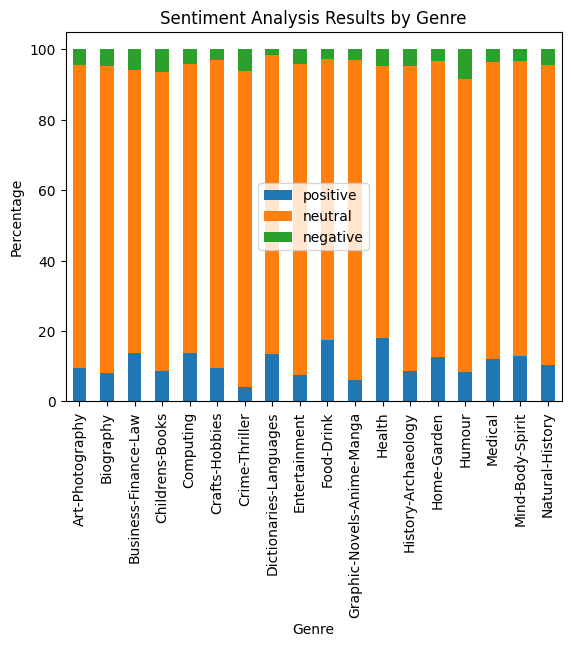

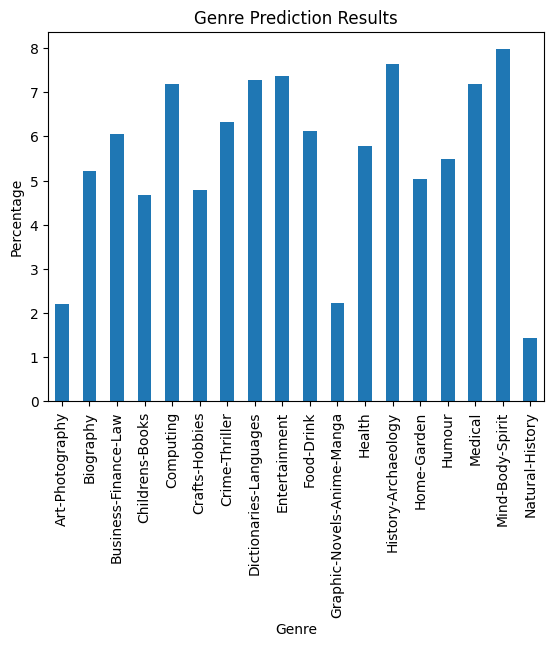

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

sentiments = ['positive', 'neutral', 'negative']
genre_sentiments = pd.DataFrame(columns=['Genre', 'positive', 'neutral', 'negative'])
for genre in df['Genre'].unique():
    genre_df = df[df['Genre'] == genre]
    genre_sentiments.loc[len(genre_sentiments)] = [genre] + [genre_df['sentiment'].value_counts(normalize=True).get(sentiment, 0) * 100 for sentiment in sentiments]

# Sort the DataFrame by the 'Genre' column
genre_sentiments.sort_values(by='Genre', inplace=True)

# Plot the percentage of sentiments for each genre
genre_sentiments.plot(x='Genre', kind='bar', stacked=True)
plt.title('Sentiment Analysis Results by Genre')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()

# Calculate the percentage of predicted genres
predicted_genres = df['predicted_genre'].value_counts(normalize=True) * 100

# Sort the Series by the index (which is the genre names)
predicted_genres.sort_index(inplace=True)

# Plot the percentage of predicted genres
predicted_genres.plot(kind='bar')
plt.title('Genre Prediction Results')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()


# TEST FUNCTION

In [26]:
def test(image):
    from keras.utils import pad_sequences
    import pickle
    import pytesseract
    from PIL import Image
    from keras.models import load_model
    import pandas as pd
    import string
    
    df = pd.read_csv("Extracted_data.csv")

    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    img = Image.open(image)
    text = pytesseract.image_to_string(img)
    
    text = text.lower()
    text = ' '.join(text.split())
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    print("Book Title : ",text)
    
    # Load the saved tokenizer from file
    with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
        
    if text != "":
        X = tokenizer.texts_to_sequences([text])
        X = pad_sequences(X)

        model = load_model("model.h5")
        y_pred = model.predict(X,verbose=0)
        y_pred = np.argmax(y_pred,axis=1)

        dict_ = {}
        for i in enumerate(list(df['Genre'].unique())):
            dict_[i[0]] = i[1]

        print("Predicted Genre :: ",dict_[y_pred[0]])
    else:
        print("Please choose another Image!")

In [49]:
test(r"book-covers\Biography\0000859.jpg")

Book Title :  buffett ‘the making of an american capinalise
Predicted Genre ::  Biography
